# Plot regression R2 scores and coefficients

After fitting regression models to the spectral power at each ECoG electrode, we can plot the R2 scores fit to withheld data (including delta R^2 scores that indicate the importance of each feature), along with coefficient values. Note that these values are averaged across all permutations of train/test splits. This notebook will generate Figs. 7 and 8 from the paper.

In [1]:
%matplotlib inline
import natsort,glob
import numpy as np
import pandas as pd
from mne.time_frequency import read_tfrs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize,LinearSegmentedColormap
from matplotlib import gridspec
from tqdm import tqdm_notebook as tqdm
from astropy.stats import mad_std

#Custom packages
import config
from tfr_utils import plot_ecog_electrodes_mni_in_order,add_colorbar
from regression_utils import compute_r2_score_colors,compute_reg_coef_colors,compute_ind_subj_r2_colors

/home/stepeter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Set parameters

In [2]:
reg_lp = '.../naturalistic_reaches/tfr/regressions/'
tfr_lp = '.../naturalistic_reaches/tfr/'
plot_sd_coef = False #whether to plot coefficient SD (True) or mean (False) across permutations

#Load config parameters
r2_thresh = config.constants_regress['r2_thresh'] #threshold for well-fit models
chan_labels = config.constants_regress['chan_labels'] #decide which electrodes to plot ('allgood' means plot only marked good electrodes)
vscale_r2 = config.constants_regress['vscale_r2']

r2_plt_titles = config.constants_regress['r2_plt_titles']
coef_plt_titles = config.constants_regress['coef_plt_titles']
zero_rem_thresh = config.constants_regress['zero_rem_thresh']

if plot_sd_coef:
    vscale_coef = config.constants_regress['vscale_coef_sd']
else:
    vscale_coef = config.constants_regress['vscale_coef']

### Load in regression results

In [3]:
reg_coefs = np.load(reg_lp+'reg_coefs.npy')
reg_r2_train = np.load(reg_lp+'reg_r2_train.npy')
reg_r2_test = np.load(reg_lp+'reg_r2_test.npy')
del_r2_train = np.load(reg_lp+'del_r2_train.npy')
del_r2_test = np.load(reg_lp+'del_r2_test.npy')
n_subjs,max_chan_num,n_coefs,n_freqs,n_perms = reg_coefs.shape

#Compute measures for plotting
#1) This should be average (used for deciding which electrodes to plot)
reg_r2_test_ave = np.mean(reg_r2_test,axis=-1)

#2) These are the values to be plotted (can be average or variance measure)
r2_dat_plot = np.mean(reg_r2_test,axis=-1)
del_r2_dat_plot = np.mean(del_r2_test,axis=-1)
if plot_sd_coef:
    reg_coefs_dat_plot = np.std(reg_coefs,axis=-1)
else:
    reg_coefs_dat_plot = np.mean(reg_coefs,axis=-1)

### Find number of electrodes per subject with positive R2 scores

In [4]:
lo_band,hi_band,elec_locs,bad_chans_all = [],[],[],[]
for i in range(n_subjs):
    fname_tfr = natsort.natsorted(glob.glob(tfr_lp+'subj_'+str(i+1).zfill(2)+'*.h5'))[-1]
    power = read_tfrs(fname_tfr)[0]
    bad_chans = power.info['bads']
    ch_list = np.asarray(power.info['ch_names'])
    
    #Save electrode locations
    elec_locs_temp = np.zeros([len(power.info['chs']),3])
    for k in range(len(power.info['chs'])):
        elec_locs_temp[k,:] = power.info['chs'][k]['loc'][:3]
    elec_locs.append(elec_locs_temp)
        
    inds2drop = []
    for bad_ch in bad_chans:
        inds2drop.append(np.nonzero(ch_list==bad_ch)[0][0])
        
    inds2drop = np.asarray(inds2drop)
    bad_chans_all.append(inds2drop)
    good_chans = np.setdiff1d(np.arange(len(ch_list)),inds2drop)
    lo_band.append(len(np.nonzero(reg_r2_test_ave[i,good_chans,0]>r2_thresh)[0]))
    hi_band.append(len(np.nonzero(reg_r2_test_ave[i,good_chans,1]>r2_thresh)[0]))

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_6_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_03_day_6_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_04_day_7_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_05_day_7_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_06_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_07_day_7_l_allEpochs_tfr.h5 ...
Add

### Plot number of electrodes per subject with positive R2 scores

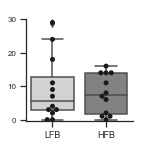

In [5]:
#Put into dataframe for plotting
subj_ids = np.arange(n_subjs).tolist()
subj_ids = [str(val).zfill(2) for val in subj_ids]
df = pd.DataFrame(list(zip(2*subj_ids,lo_band+hi_band,n_subjs*['LFB']+n_subjs*['HFB'])),
                  columns=['Patient','Num_sig_r2','Band'])

#Plot results
f, ax = plt.subplots(1,1,figsize=(1.92,2))
my_pal = {"LFB": [210/255]*3, "HFB": [130/255]*3}
ax = sns.boxplot(x='Band', y='Num_sig_r2',data=df,order=['LFB','HFB'], palette=my_pal,ax=ax)
ax = sns.swarmplot(x='Band', y='Num_sig_r2',data=df,order=['LFB','HFB'],ax=ax,color='k')#,size=10)
ax.set_xlabel('')
ax.set_ylabel('',fontsize=18,fontweight='bold')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(-.5,32)
ax.set_yticks([0,10,20,30])
ax.spines['left'].set_bounds(-.5,30)
plt.setp(ax.get_yticklabels(), fontsize=8,fontweight='normal', fontname="Arial")
plt.setp(ax.get_xticklabels(), fontsize=9,fontweight='normal', fontname="Arial")
plt.show()

### Plot R2 scores and delta R2 scores for each feature (low frequency band on top, high frequency band on bottom)

/home/stepeter/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stepeter/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


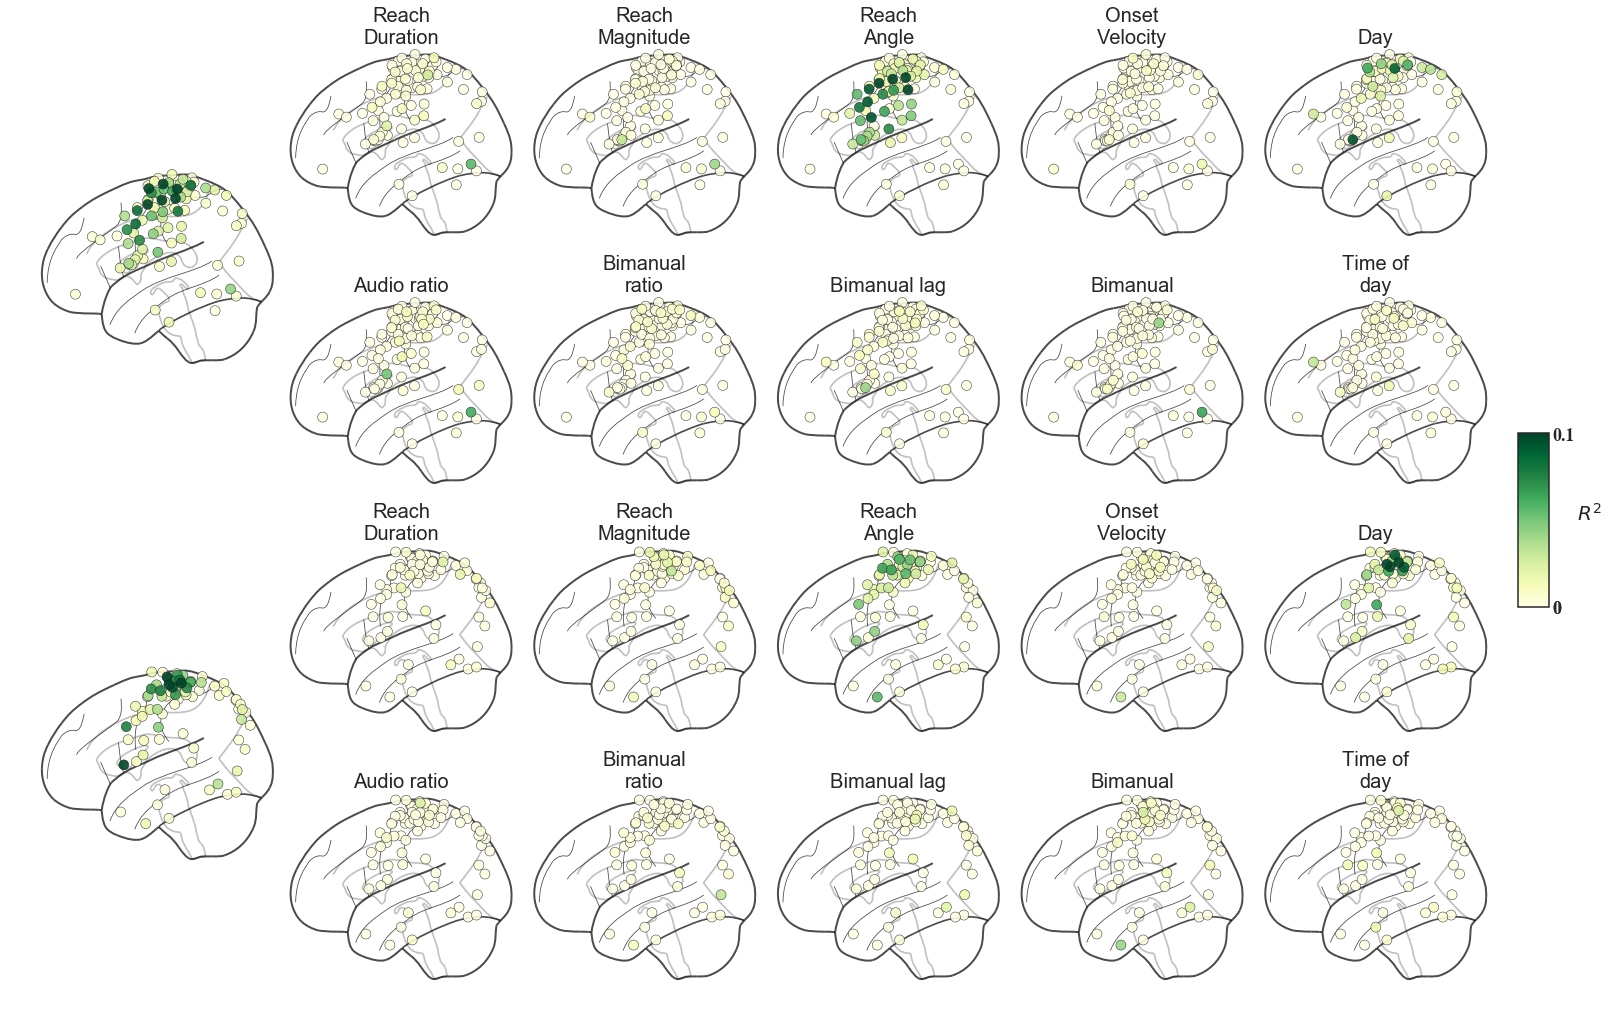

In [6]:
#Note that a runtime warning will appear because there are NaN entries padding the channel size
#of the array across subjects


colors_all,colors_all_r2,vals_all_r2imp,cmap_r2 = compute_r2_score_colors(r2_dat_plot,del_r2_dat_plot,n_subjs,
                                                                       n_freqs,n_coefs,reg_r2_test_ave,
                                                                       r2_thresh)

#Perform plotting


fig = plt.figure(figsize=(4*7.1,4*4.3))
half_len = n_coefs//2
nrows,ncols = 4,half_len+1
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols,figure=fig,width_ratios= [1]*ncols,
                       height_ratios= [1]*nrows,wspace=0, hspace=.3)

fig.subplots_adjust(right=0.84)
for j in range(n_freqs):
    ax = [None]*(n_coefs+1)
    for s in range(n_coefs):
        rem_zero_chans = True
        
        if s==0:
            ax[s] = fig.add_subplot(gs[(j*2):(j*2+2),0])
        elif s>=colors_all.shape[2]-2:
            ax[s] = fig.add_subplot(gs[s+2*j-(colors_all.shape[2]-2),-1])
        else:
            ax[s] = fig.add_subplot(gs[(s+1)//ncols+2*j,s%(ncols-1)+(s//(ncols-1))])
        
        plot_ecog_electrodes_mni_in_order(elec_locs,bad_chans_all,chan_labels,num_grid_chans=64,node_size=100,
                                          colors_in=colors_all_r2[:,j],
                                          elec_col_suppl_in=colors_all[:,j,s],alpha=.9,sides_2_display='l',
                                          node_edge_colors='k',edge_linewidths=.5,ax_in=ax[s],
                                          rem_zero_chans=rem_zero_chans,zero_rem_thresh=zero_rem_thresh,
                                          allLH=True,sort_vals_in = vals_all_r2imp[:,j,s],sort_abs=True)
        ax[s].set_title(r2_plt_titles[s],fontweight='normal',fontsize=20,fontname="Arial")
add_colorbar(fig,vscale_r2[0],vscale_r2[1],cmap_r2,label_name=r'$R^2$',height=.14,width=.015,label_fontsize=20,tick_fontsize=18)

plt.show()

### Plot regression coefficients for intercept and each feature (low frequency band on top, high frequency band on bottom)

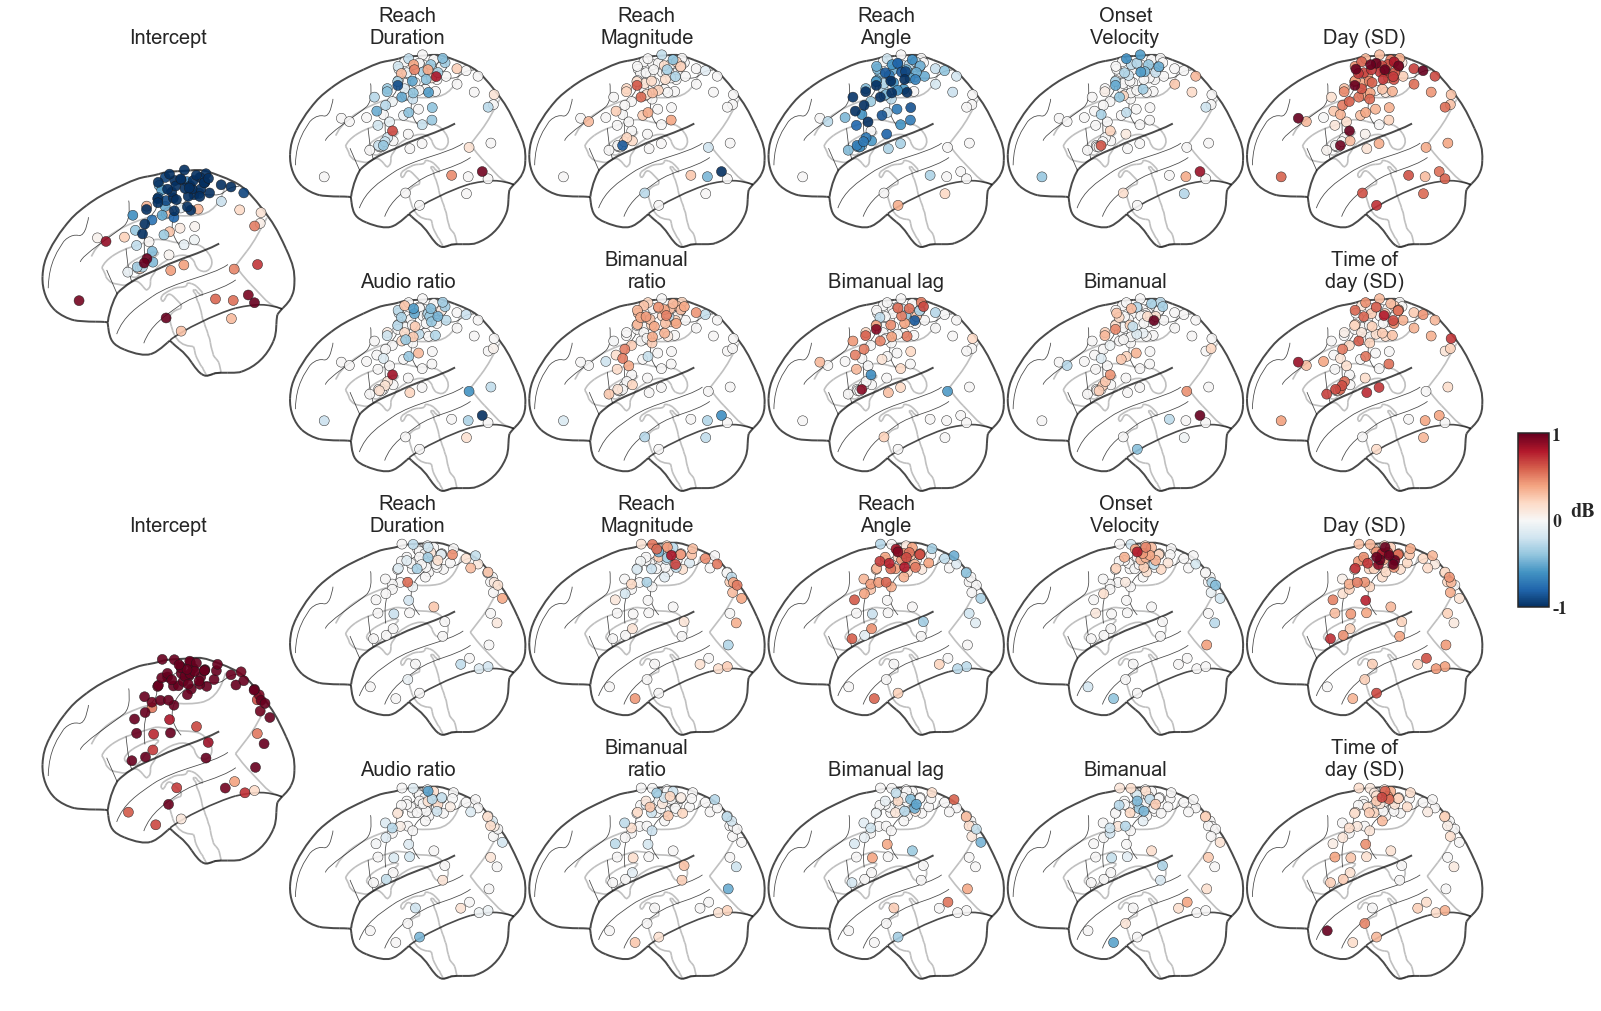

In [7]:
colors_all,vals_all_coefs,cmap_coef = compute_reg_coef_colors(reg_coefs_dat_plot,n_subjs,n_freqs,
                                                         n_coefs,plot_sd_coef=plot_sd_coef)

n_rows,n_cols = 4,3
fig = plt.figure(figsize=(4*7.1,4*4.3))
half_len = int(n_coefs/2)
nrows,ncols = 4,half_len+1
gs = gridspec.GridSpec(nrows=nrows, 
                       ncols=ncols, 
                       figure=fig, 
                       width_ratios= [1]*ncols,
                       height_ratios= [1]*nrows,
                       wspace=-0.1, hspace=.2
                      )


fig.subplots_adjust(right=0.84)
for j in range(colors_all.shape[1]):
    ax = [None]*(n_coefs+1)
#     f, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True,figsize=(14,10))
    for s in range(colors_all.shape[2]):
        if s==0:
            ax[s] = fig.add_subplot(gs[(j*2):(j*2+2),0])
        elif s>=colors_all.shape[2]-2:
            ax[s] = fig.add_subplot(gs[s+2*j-(colors_all.shape[2]-2),-1])
        else:
            ax[s] = fig.add_subplot(gs[(s+1)//ncols+2*j,s%(ncols-1)+(s//(ncols-1))])
            
        plot_ecog_electrodes_mni_in_order(elec_locs,bad_chans_all,chan_labels,num_grid_chans=64,node_size=100,
                                          colors_in=colors_all_r2[:,j],
                                          elec_col_suppl_in=colors_all[:,j,s],alpha=.9,sides_2_display='l',
                                          node_edge_colors='k',edge_linewidths=.5,ax_in=ax[s],
                                          rem_zero_chans=rem_zero_chans,zero_rem_thresh=zero_rem_thresh,
                                          allLH=True,sort_vals_in = vals_all_coefs[:,j,s],sort_abs=True)
        ax[s].set_title(coef_plt_titles[s],fontweight='normal',fontsize=20,fontname="Arial")
add_colorbar(fig,vscale_coef[0],vscale_coef[1],cmap_coef,label_name='dB',
             height=.14,width=.015,label_fontsize=20,tick_fontsize=18)        

plt.show()

### Plot R2 scores for each subject (low frequency band on top, high frequency band on bottom)

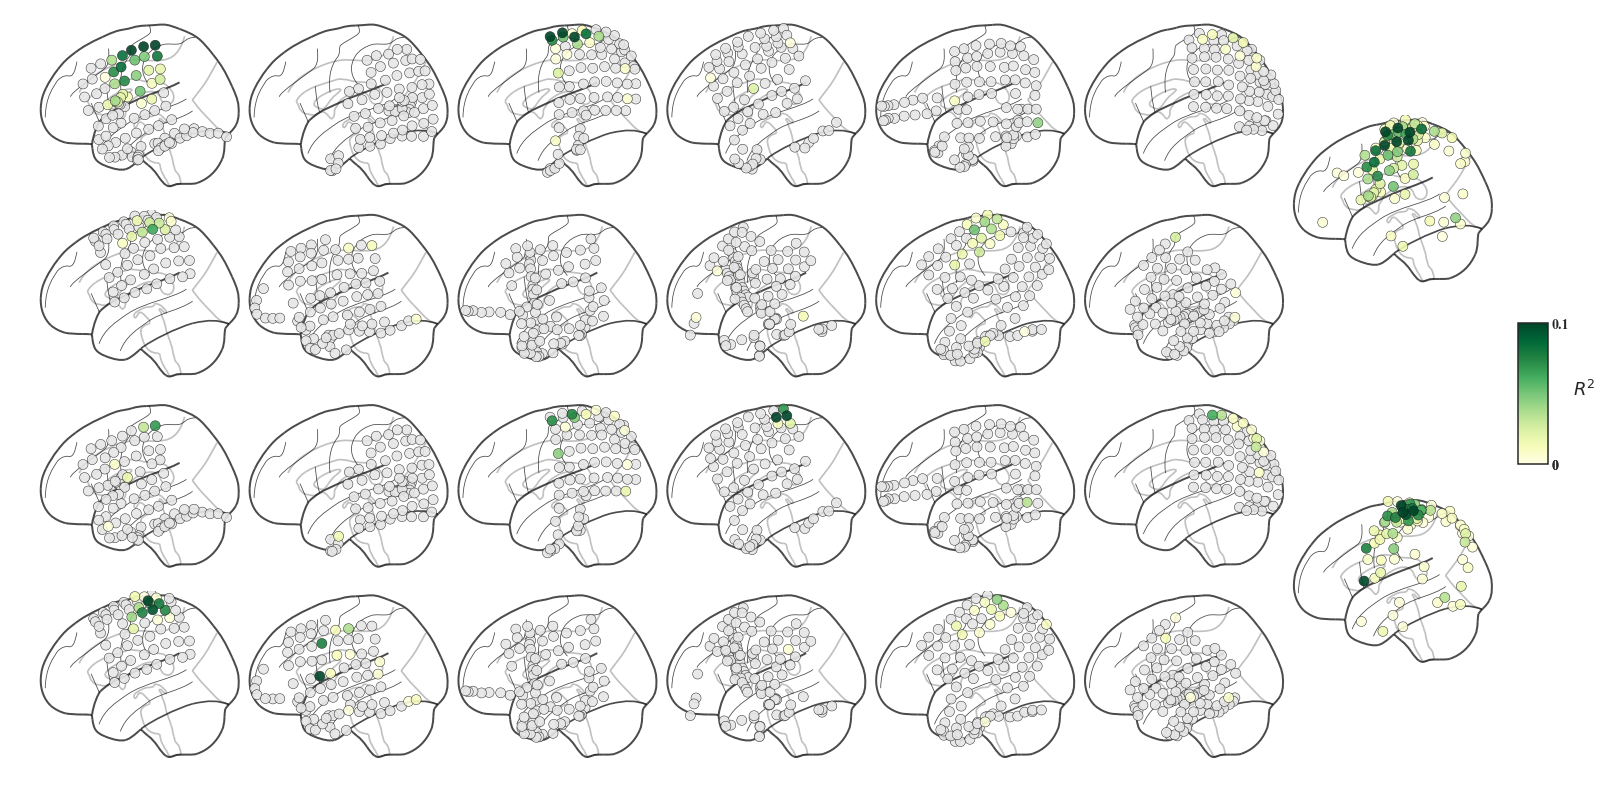

In [8]:
colors_all_r2_new,vals_all_r2 = compute_ind_subj_r2_colors(reg_r2_test_ave,n_subjs,n_freqs,r2_thresh)

n_rows,n_cols = 4,3
fig = plt.figure(figsize=(4*7.1,4*3.5))
half_len = int(n_subjs/2)
nrows,ncols = 4,half_len+1
gs = gridspec.GridSpec(nrows=nrows, 
                       ncols=ncols, 
                       figure=fig, 
                       width_ratios= [1]*ncols,
                       height_ratios= [1]*nrows,
                       wspace=0, hspace=0
                      )
fig.subplots_adjust(right=0.84)
for j in range(n_freqs):
    ax = [None]*(n_subjs+1)
    for s in range(n_subjs+1):
        if s>=n_subjs:
            ax[s] = fig.add_subplot(gs[(j*2):(j*2+2),-1])
            plot_ecog_electrodes_mni_in_order(elec_locs,bad_chans_all,chan_labels,num_grid_chans=64,node_size=100,
                                              colors_in=colors_all_r2[:,j],elec_col_suppl_in=colors_all_r2_new[:,j],
                                              alpha=.9,sides_2_display='l',
                                              node_edge_colors='k',edge_linewidths=.5,ax_in=ax[s],
                                              rem_zero_chans=rem_zero_chans,zero_rem_thresh=zero_rem_thresh,
                                              allLH=True,sort_vals_in = vals_all_r2[:,j],sort_abs=True)
        else:
            ax[s] = fig.add_subplot(gs[s//half_len+2*j,s%half_len])
            plot_ecog_electrodes_mni_in_order([elec_locs[s]],[bad_chans_all[s]],chan_labels,num_grid_chans=64,node_size=100,
                                              colors_in=colors_all_r2[s,j],elec_col_suppl_in=colors_all_r2_new[s,j],
                                              alpha=.9,sides_2_display='l',
                                              node_edge_colors='k',edge_linewidths=.5,ax_in=ax[s],
                                              rem_zero_chans=False,zero_rem_thresh=zero_rem_thresh,
                                              rem_zero_chans_show=True,rem_show_col=[.9,.9,.9],
                                              allLH=True,sort_vals_in = vals_all_r2[s,j],sort_abs=True)
add_colorbar(fig,vscale_r2[0],vscale_r2[1],cmap_r2,label_name=r'$R^2$',height=.14,width=.015)
plt.show()